In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re


Coding Baum-Welch Algorithm from scratch

In [ ]:
def forward(states, sequence, a, b, pi, key):
    N = len(states)
    T = len(sequence)
    pi = pi[key] # prob of state i, since 2 states, let's half it be 0.5, 0.5 initially
    i = key # holds the first state

    # Pseudocount to handle zeros
    pseudocount = 1e-100
    # for all possible states, and the first actual state (alpha)
    # i.e. alpha i for all i has been caluclated given yt
    alpha = np.zeros((N, T))
    alpha[:,0] = pi * b[:,int(sequence[0])] + pseudocount


    # next, we have to do iterations to calculate alpha at different times t
    # we need all alpha values since it is going to be summed up to calculate gamma
    
    for t in range(1, T):
        for j in range(N):
            alpha[j][t] = sum(alpha[i][t-1]*a[i][j]*b[j][int(sequence[t])] for i in range(N)) + pseudocount

    return alpha

In [ ]:
def backward(states, sequence, a, b):
    N = len(states)
    T = len(sequence)
    beta = np.zeros((N, T))

    # Pseudocount to handle zeros
    pseudocount = 1e-100

    # Initialization
    beta[:, -1] = 1  # Set the last column to 1

    # Recursion
    for t in range(T - 2, -1, -1):
        for i in range(N):
            beta[i, t] = sum(a[i, j] * b[j, int(sequence[t + 1])] * beta[j, t + 1] for j in range(N)) + pseudocount

    return beta

In [ ]:
def train(a, b, pi, sequence, states, key, n_iterations = 100, tol=1e-6):
    #Baum-Welch algorithm for HMM
    # calculate gamma, xi, and then update a and b parameters
    N = len(states)
    T = len(sequence)
    
    # M is the number of possible observations i.e. number of columns
    M = b.shape[1]

    prev_log_likelihood = 0

    for iteration in range(n_iterations):
        alpha = forward(states, sequence, a, b, pi, key)
        beta = backward(states, sequence, a, b)

        print(f"Alpha: {alpha}")
        print(f"Beta:{beta}")

        # Pseudocount to handle zeros
        pseudocount = 1e-100
        gamma = alpha * beta
        # print(gamma)
        denominator = np.sum(gamma, axis=0, keepdims=True) # same for all i
        gamma = gamma/denominator + pseudocount

        print(f"gamma:{gamma}") 

        xi = np.zeros((N, N, T - 1))

        for i in range(N):
            for j in range(N):
                for t in range(T - 1):
                    numerator = alpha[i, t] * a[i, j] * b[j, int(sequence[t + 1])] * beta[j, t + 1]
                    denominator = np.sum(alpha[k, t] * a[k, l] * b[l, int(sequence[t + 1])] * beta[l, t + 1] for k in range(N) for l in range(N))
                    xi[i, j, t] = (numerator / denominator) + pseudocount

        print(f"Xi: {xi}")


        # update a and b
        # M-step
        '''
        sequence == k creates a boolean array of the same length as sequence, where each element is True if the corresponding element in sequence is equal to k, and False otherwise.
    mask = (sequence == k) assigns this boolean array to the variable mask.
    In the context of the Baum-Welch algorithm or similar algorithms for Hidden Markov Models (HMMs), this kind of mask is often used to select specific observations in the computation of probabilities. For example, 
    it might be used to sum over only the observations that match a particular value, which is relevant when updating the emission matrix b.
        '''
        # a = (np.sum(xi, axis=2) + pseudocount)/ np.sum(gamma[:, :-1], axis=1, keepdims=True) 
        for i in range(N):  # N is the number of states
            for j in range(N):  # N is the number of states
                numerator = np.sum(xi[i, j, :])
                denominator = np.sum(gamma[i, :])
                a[i, j] = (numerator+pseudocount) / (denominator+pseudocount) 


        b = np.zeros((N, M))
        # print(gamma.shape)
        gamma_sum = np.sum(gamma, axis=1)
        
        obs = []
        for i in sequence:
            obs.append(int(i))
        obs = np.array(obs)

        for j in range(N):
            for k in range(M):
                mask = (obs==k) # for indicative function i.e. 1 if observed = yt, else 0
                b[j, k] = (np.sum(gamma[j]*mask)+ pseudocount) / (np.sum(gamma[j]) + pseudocount) 
        

        # Normalize rows to ensure each row sums to 1.0
        a = a / np.sum(a, axis=1)[:, np.newaxis]
        b = b / np.sum(b, axis=1)[:, np.newaxis]

        print(f"a = {a}, b = {b}")

        # Log Likelihood Calculation
        log_likelihood = np.sum(np.log(np.sum(alpha, axis=0)))

        # Convergence Check
        if np.abs(log_likelihood - prev_log_likelihood) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break

        prev_log_likelihood = log_likelihood

    return a, b, pi

In [ ]:
def predict(sequence, states, a, b, pi):
    # Makes use of the viterbi algorithm to predict best path
    # Initialize Variables
    T = len(sequence)
    N = len(states)

    # Pseudocount to handle zeros
    pseudocount = 1e-100

    viterbi_table = np.zeros((N, T)) # delta
    backpointer = np.zeros((N, T)) # psi

    # Initialization step, for t = 0
    print(int(sequence[0]))
    viterbi_table[:, 0] = pi * b[:, int(sequence[0])] + pseudocount

    # Calculate Probabilities
    for t in range(1, T):
        for s in range(N):
            
            max_prob = max(viterbi_table[prev_s][t-1] * a[prev_s][s] for prev_s in range(N)) * b[s][int(sequence[t])] 
            viterbi_table[s][t] = max_prob + pseudocount
            backpointer[s][t] = np.argmax([viterbi_table[prev_s][t-1] * a[prev_s][s]for prev_s in range(N)])

    #Traceback and Find Best Path
    best_path = []
    last_state = np.argmax(viterbi_table[:, -1])

    best_path.append(last_state)
    best_prob = 1.0
    for t in range(T-2, -1, -1):
        last_state = last_state = np.argmax(viterbi_table[:, t])
        best_prob *= (viterbi_table[last_state, t] + pseudocount)
        best_path.append(last_state) # i.e. add to start of list

        
    return best_path


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hmmlearn import hmm



gen_model = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params = 'se')

gen_model.startprob_ = np.array([1.0, 0.0])

gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.1, 0.9]])

gen_model.emissionprob_ = \
    np.array([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],
              [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 2]])

# simulate the loaded dice rolls
rolls, gen_states = gen_model.sample(30000)

Transition Model:


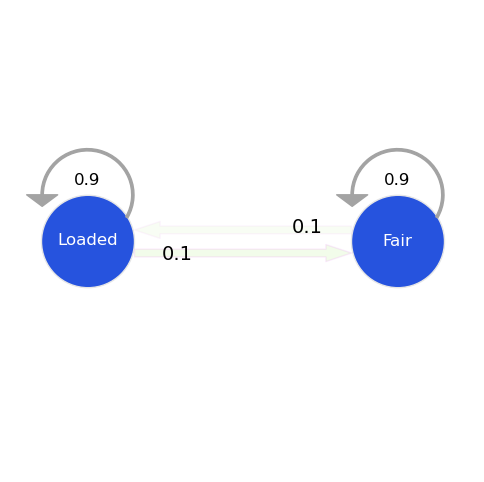

Emission Matrix:


,Fair,Unfair
1,0.166667,0.1
2,0.166667,0.1
3,0.166667,0.1
4,0.166667,0.1
5,0.166667,0.1


In [12]:
import matplotlib.pyplot as plt 
# Import the MarkovChain class from markovchain.py
from markovchain import MarkovChain

P = gen_model.transmat_
mc = MarkovChain(P, ['Fair', 'Loaded'])
print("Transition Model:")
mc.draw()


data = {'Fair': gen_model.emissionprob_[0], 'Unfair': gen_model.emissionprob_[1]}
df_emission = pd.DataFrame(data, index=['1', '2', '3', '4', '5', '6'])

print("Emission Matrix:")
df_emission.head()

In [13]:
pd.DataFrame({'Roll': rolls.flatten()[0:10]+1, 'Coin_State': gen_states.flatten()[0:10]}).head()

,Roll,Coin_State
0,6,0
1,1,0
2,2,0
3,6,1
4,1,1


C:\Users\Anu2001\AppData\Local\Temp\ipykernel_10324\3287461216.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


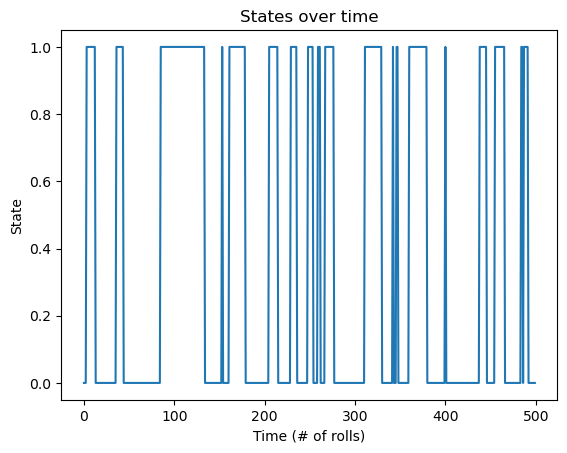

In [14]:
# plotting the states of the first 500 coin flips
fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('States over time')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
fig.show()

C:\Users\Anu2001\AppData\Local\Temp\ipykernel_10324\2992798780.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


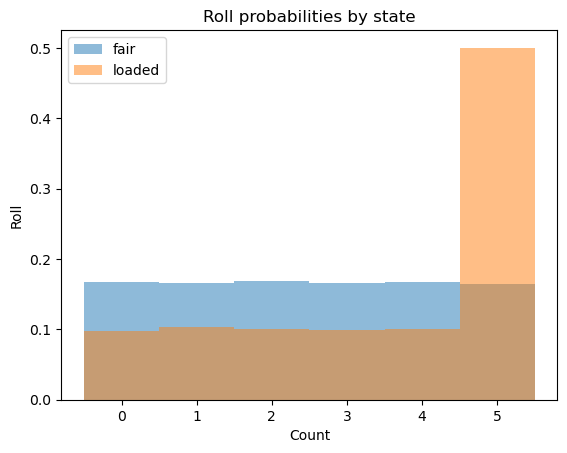

In [15]:
# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.set_title('Roll probabilities by state')
ax.set_xlabel('Count')
ax.set_ylabel('Roll')
ax.legend()
fig.show()

In [40]:
print(len(gen_states[gen_states.shape[0] // 2:]))

15000


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


Generated score: -26140.512085616556
Best score:      -26136.572745325924
Transmission Matrix Generated:
[[0.949 0.051]
 [0.135 0.865]]

Transmission Matrix Recovered:
[[0.903 0.097]
 [0.058 0.942]]


Emission Matrix Generated:
[[0.161 0.16  0.171 0.167 0.166 0.173]
 [0.095 0.111 0.085 0.083 0.093 0.533]]

Emission Matrix Recovered:
[[0.106 0.118 0.103 0.1   0.107 0.467]
 [0.165 0.164 0.175 0.171 0.17  0.155]]




C:\Users\Anu2001\AppData\Local\Temp\ipykernel_10324\2874475397.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


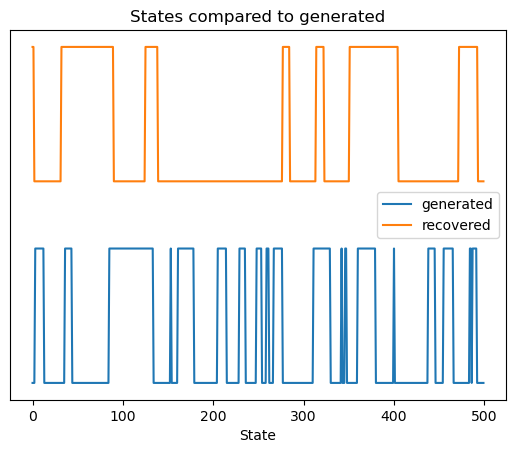

In [42]:

# split our data into training and validation sets (50/50 split)
X_train = rolls[:rolls.shape[0] // 2]
X_test = rolls[rolls.shape[0] // 2:]
y_test = np.array(gen_states[gen_states.shape[0] // 2:])
gen_model = gen_model.fit(X_train)

# check base score (non-tuned model)
gen_score = gen_model.score(X_test)

# best_score = best_model = None
# n_fits = 50
# np.random.seed(13)
# for idx in range(n_fits):
#     model = hmm.CategoricalHMM(
#         n_components=2, random_state=idx,
#         init_params='se')  # don't init transition, set it below
#     # we need to initialize with random transition matrix probabilities
#     # because the default is an even likelihood transition
#     # we know transitions are rare (otherwise the casino would get caught!)
#     # so let's have an Dirichlet random prior with an alpha value of
#     # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
#     # of the time
#     model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
#                                 np.random.dirichlet([0.1, 0.9])])
#     model.fit(X_train)
#     score = model.score(X_test)
#     if best_score is None or score > best_score:
#         best_model = model
#         best_score = score
print(f'Generated score: {gen_score})
# print(f'Generated score: {gen_score}\nBest score:      {best_score}')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
# states = best_model.predict(rolls)

states = gen_model.predict(X_test)
# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(states[:500] + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
ax.legend()
fig.show()

# %%
# Let's check our learned transition probabilities and see if they match.

print(f'Transmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n\n')

# %%
# Finally, let's see if we can tell how the die is loaded.

print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n\n')

# %%
# In this case, we were able to get very good estimates of the transition and
# emission matrices, but decoding the states was imperfect. That's because
# the decoding algorithm is greedy and picks the most likely series of states
# which isn't necessarily what happens in real life. Even so, our model could
# tell us when to watch for the loaded die and we'd have a better chance at
# catching them red-handed.

Confusion Matrix:


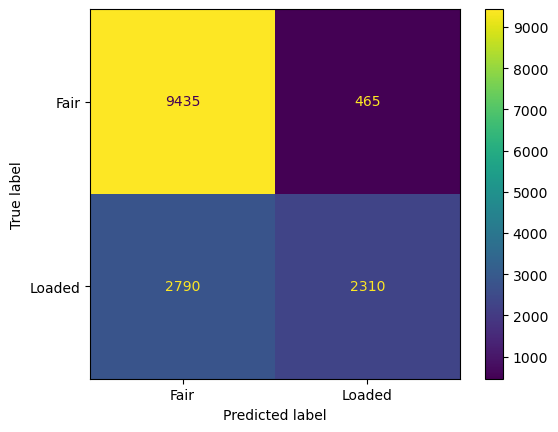

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      9900
           1       0.83      0.45      0.59      5100

    accuracy                           0.78     15000
   macro avg       0.80      0.70      0.72     15000
weighted avg       0.79      0.78      0.76     15000



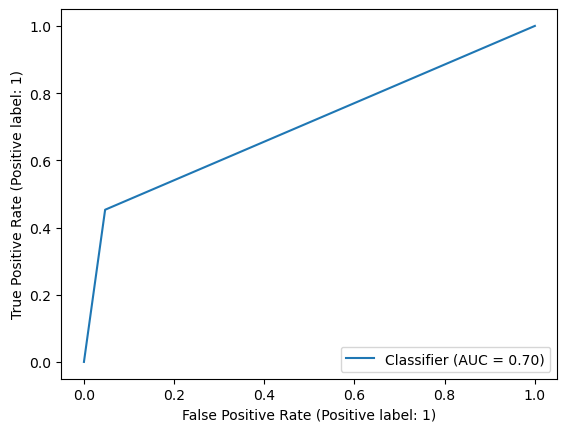

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

# True states (hidden states)
true_states = y_test
predicted_states = states

# Evaluate confusion matrix
conf_matrix = confusion_matrix(true_states, predicted_states)
# Display confusion matrix
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Fair', 'Loaded'])
disp.plot()
plt.show()

# Evaluate classification report
class_report = classification_report(true_states, predicted_states)

# Display classification report
print("Classification Report:")
print(class_report)

RocCurveDisplay.from_predictions(true_states, predicted_states)